<a href="https://colab.research.google.com/github/parkdoyun/google_colab/blob/master/Project_TF_hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# TF-HUB 함수 이용

In [1]:
# ctrl+f9 -> 모두 실행
# ctrl+f10 -> 이후 셀 실행

# google 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install face_recognition

     |████████████████████████████████| 100.1 MB 4.8 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566185 sha256=9dc69c51ffd618606ce33d765eb10ca57adca675011e083f2ecc99bf5384bbfa
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [11]:
# 스타일 유형 설정
#@title 스타일 설정 { form-width: "20%" }
style_type = "1. Gogh" #@param ["1. Gogh", "2. Kandinsky", "3. LeeJungSeop", "4. Matisse", "5. Monet", "6. Picasso", "7. ChunKyungJa", "8. Sketch"]

# 이 밑부터 자동 실행 ctrl + f10

<IPython.core.display.Javascript object>

Saved to photo.jpg


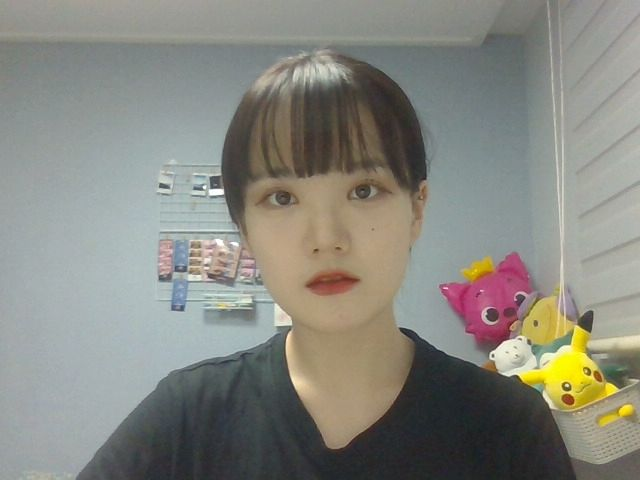

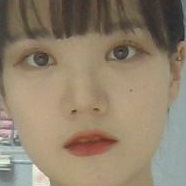

-1

In [6]:
# 웹캠 사진 출력 함수 take_photo()
# 캡처 버튼 누르면 -> 'photo.jpg'로 저장

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# 웹캠으로 사진 찍어서 얼굴 부분만 크롭
# 해당 이미지 저장하기 (photo_trim.jpg)

import cv2
import numpy as np
import face_recognition
from google.colab.patches import cv2_imshow

# 사진 찍기
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# 사진에 네모박스 치기
import cv2
import numpy as np
import face_recognition

img1 = face_recognition.load_image_file('photo.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

# face_recognition이 검출한 얼굴의 위치 가져옴
# 한 이미지에 사람 많다면 각 구역에 대한 위치 반환

faceLoc = face_recognition.face_locations(img1)[0]
encodeImg1 = face_recognition.face_encodings(img1)[0] # 얼굴 구역 내 세밀한 특징 인코딩
# 특징 많이 보유 -> 그 사람이라 판단, 다른 사진들도 학습 & 예측 가능

# 이미지 얼굴 부분 자르고 따로 저장
x = faceLoc[3]; y = faceLoc[0] # 자르고 싶은 지점의 x좌표, y좌표
w = abs(faceLoc[1]-faceLoc[3]); h = abs(faceLoc[2]-faceLoc[0]) # x로부터 width, y로부터 height 지정

img_trim = img1[y:y + h, x:x+w] # trim한 결과를 img_trim에 넣는다
cv2.imwrite('photo_trim.jpg', img_trim) # 저장

cv2_imshow(img_trim) # display

#cv2.imwrite('photo_trim.jpg', img_trim) # 흑백으로 다시 저장

cv2.waitKey(0)

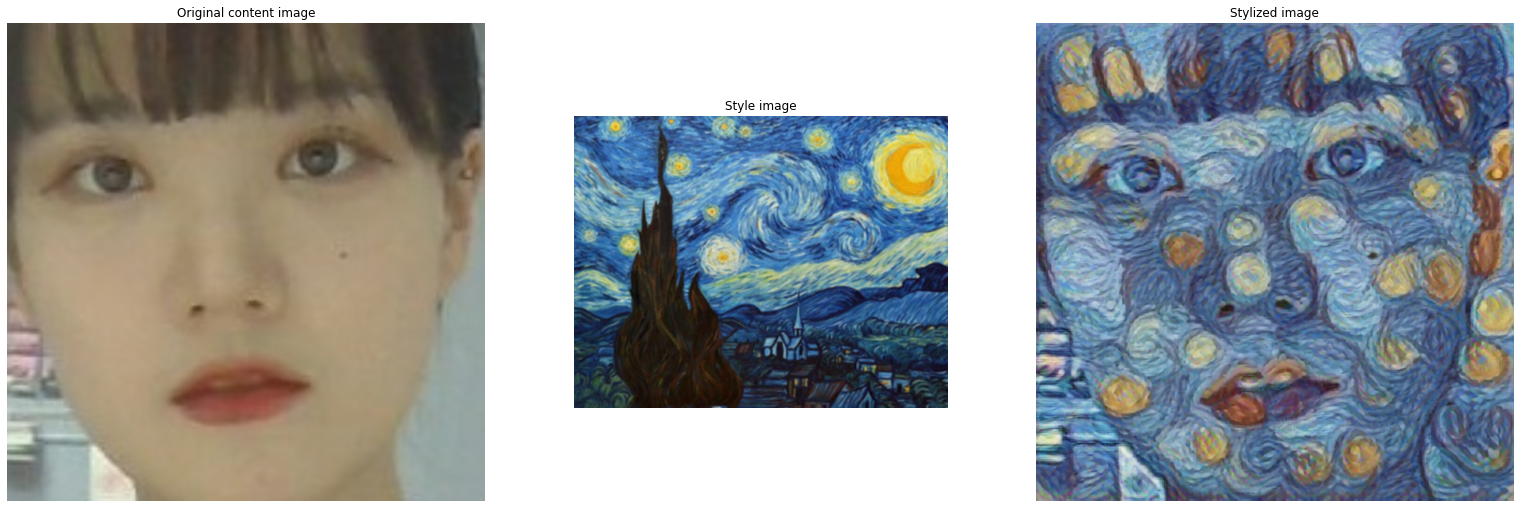

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# set up
# 오른쪽의 스타일 유형 설정 후 코드 실행
# 설정
# import tf2 and all relevant dependencies

import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import PIL.Image

# print("TF Version: ", tf.__version__)
# print("TF Hub version: ", hub.__version__)
# print("Eager mode enabled: ", tf.executing_eagerly())
# print("GPU available: ", tf.config.list_physical_devices('GPU'))

# define image loading, saving and visualization functions
# 함수 정의

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# load image

content_image_url = 'photo_trim.jpg' # 크롭 후 생성한 사진
style_type_num = style_type[0]

# 스타일 유형 선택 -> 1 ~ 8 중 선택
if style_type_num == '1': # Gogh
  style_image_url = '/content/drive/MyDrive/Colab_Notebooks/styles/style_Gogh.jpeg' # 스타일
elif style_type_num == '2': # Kandinsky
  style_image_url = '/content/drive/MyDrive/Colab_Notebooks/styles/style_Kandinsky.jpeg' # 스타일
elif style_type_num == '3': # LeeJungSeop
  style_image_url = '/content/drive/MyDrive/Colab_Notebooks/styles/style_LeeJungSeop.jpg' # 스타일
elif style_type_num == '4': # Matisse
  style_image_url = '/content/drive/MyDrive/Colab_Notebooks/styles/style_Matisse.jpg' # 스타일
elif style_type_num == '5': # Monet
  style_image_url = '/content/drive/MyDrive/Colab_Notebooks/styles/style_Monet.jpeg' # 스타일
elif style_type_num == '6': # Picasso
  style_image_url = '/content/drive/MyDrive/Colab_Notebooks/styles/style_Piccasso.jpeg' # 스타일
elif style_type_num == '7': # ChunKyungJa
  style_image_url = '/content/drive/MyDrive/Colab_Notebooks/styles/style_ChunKyungJa.jpg' # 스타일
else: # 8 Sketch
  style_image_url = '/content/drive/MyDrive/Colab_Notebooks/drawing2.jpg' # 스타일

output_image_size = 384

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_img(content_image_url)
style_image = load_img(style_image_url)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')

# import TF Hub module
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])

tensor_to_image(stylized_image).save('stylized_photo.jpg') # 결과물 저장

# PC에 저장
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('stylized_photo.jpg')